In [2]:
import time,os,json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient,eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data,sample_coco_minibatch,decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x,y):
    return np.max(np.abs(x-y)/(np.maximum(1e-8,np.abs(x)+np.abs(y))))

In [3]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.

    
data = load_coco_data(pca_features=True)
for k,v in data.items():
    if type(v) == np.ndarray:
        print(k,type(v),v.shape,v.dtype)
    else:
        print(k,type(v),len(v))

train_image_idxs <class 'numpy.ndarray'> (400135,) int32
train_urls <class 'numpy.ndarray'> (82783,) <U63
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
word_to_idx <class 'dict'> 1004
idx_to_word <class 'list'> 1004
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
val_urls <class 'numpy.ndarray'> (40504,) <U63
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_features <class 'numpy.ndarray'> (40504, 512) float32


In [5]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print ('next_h error: ', rel_error(expected_next_h, next_h))
print ('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054130404539434e-09
next_c error:  5.8143123088804145e-09


In [7]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print ('dx error: ', rel_error(dx_num, dx))
print ('dh error: ', rel_error(dh_num, dh))
print ('dc error: ', rel_error(dc_num, dc))
print ('dWx error: ', rel_error(dWx_num, dWx))
print ('dWh error: ', rel_error(dWh_num, dWh))
print ('db error: ', rel_error(db_num, db))

dx error:  3.7998714734743513e-10
dh error:  3.1590825209074613e-09
dc error:  9.356841381350785e-11
dWx error:  9.825317317553804e-10
dWh error:  1.9041798638428335e-09
db error:  2.566596345755695e-10


In [9]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print ('loss: ', loss)
print ('expected loss: ', expected_loss)
print ('difference: ', abs(loss - expected_loss))

loss:  9.824459354432264
expected loss:  9.82445935443
difference:  2.2648549702353193e-12


In [12]:
N,D,W,H = 10,20,30,40
word_to_idx = {'<NULL>':0,'cat':2,'dog':3}
V = len(word_to_idx)
T=13

model = CaptioningRNN(word_to_idx,
                     input_dim=D,
                     wordvec_dim=W,
                     hidden_dim=H,
                     cell_type='lstm',
                     dtype=np.float64)

for k,v in model.params.items():
    model.params[k]=np.linspace(-1.4,1.3,num=v.size).reshape(*v.shape)
    
features = np.linspace(-0.5,1.7,num=N*D).reshape(N,D)
captions = (np.arange(N*T)%V).reshape(N,T)

loss,grad = model.loss(features,captions)
expected_loss = 9.82445935443

print('Loss:',loss)
print('expected loss: ',expected_loss)
print('difference: ',abs(loss-expected_loss))

Loss: 9.824459354432264
expected loss:  9.82445935443
difference:  2.2648549702353193e-12


/Users/wuhuali/cs231n/cs231n-master/assignment3/cs231n/optim.py:77: RuntimeWarning: invalid value encountered in sqrt
  x -= alpha * (m / (np.sqrt(v) + eps))


(Iteration 1 / 100) loss: 76.091201
(Iteration 11 / 100) loss: 38.725100
(Iteration 21 / 100) loss: 21.379702
(Iteration 31 / 100) loss: 11.892684
(Iteration 41 / 100) loss: 5.919211
(Iteration 51 / 100) loss: 2.596714
(Iteration 61 / 100) loss: 1.457052
(Iteration 71 / 100) loss: 0.368247
(Iteration 81 / 100) loss: 0.208321
(Iteration 91 / 100) loss: 0.107113


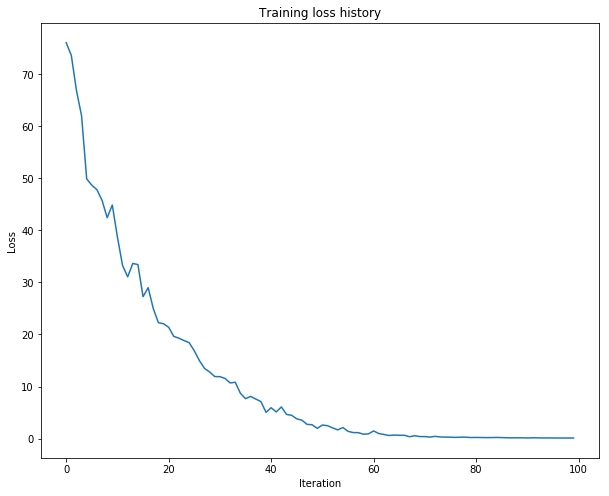

In [14]:
small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(cell_type='lstm',
                                word_to_idx=data['word_to_idx'],
                                input_dim=data['train_features'].shape[1],
                                hidden_dim=512,
                                wordvec_dim=256,
                                dtype=np.float32)

small_lstm_solver = CaptioningSolver(small_lstm_model,small_data,
                                    update_rule='adam',
                                    num_epochs=50,
                                    batch_size=25,
                                    optim_config={'learning_rate':5e-3},
                                    lr_decay=0.995,
                                    verbose=True,print_every=10)
small_lstm_solver.train()
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [15]:
for split in ['train','val']:
    minibatch = sample_coco_minibatch(small_data,split=split,batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions,data['idx_to_word'])
    
    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions,data['idx_to_word'])
    
    for gt_caption, sample_caption,url in zip(gt_captions,sample_captions,urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' %(split,sample_caption,gt_caption))
        plt.axis('off')
        plt.show()

ConnectionResetError: [Errno 54] Connection reset by peer